## Домашняя работа № 2

### 1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

### 2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

Для начала восстанавливаем историю операций по обработке датасета, выполненных на уроке

In [1]:
import pandas as pd

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

#### Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [5]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     D:\Users\Smart\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [8]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [10]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-9-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 21.6 s


In [11]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 2min 53s


А теперь в 3 строчки обучим нашу модель

In [12]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [13]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [14]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 26.9 s


In [15]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [16]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(0, 0.3233514), (6, 0.13017686), (11, 0.2710822), (23, 0.2565319)]

In [17]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: nn день обнаружить вода место экипаж стать
topic_1: организм вицепремьер вирус водитель польский польша рт
topic_2: это который год мочь человек свой весь
topic_3: nn банк область эксперимент рф глава орган
topic_4: напомнить проверка обнаружить бензин способность берег вылет
topic_5: турция топливо вероятно турецкий противник индия санкция
topic_6: фестиваль применение бизнесмен млрд бомба министерство программа
topic_7: квартира фильм тыс проект захватить год флот
topic_8: система наука это научный который журнал двигатель
topic_9: физика вниз лауреат старое праздновать перемещаться втб
topic_10: исследование путин nn это президент владимир обнаружить
topic_11: год млрд ракета стать новый это первый
topic_12: газ фонд долг клинический ремонт километр сооружение
topic_13: сша который американский это погибнуть миссия свой
topic_14: снижение мозг компьютерный су куба заполнить пепел
topic_15: земля женщина тело мужчина произойти китай высота
topic_16: журнал который планета на

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [18]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [19]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.078411,0.0,0.000000,0.869285,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,4896,0.364993,0.0,0.261962,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.155441
2,4897,0.323357,0.0,0.000000,0.000000,0.0,0.0,0.130163,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.256723,0.000000
3,4898,0.201248,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.259521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.270282,0.000000
4,4899,0.000000,0.0,0.000000,0.560166,0.0,0.0,0.000000,0.041316,0.346871,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

#### Следующий шаг - векторные представления пользователей

In [20]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [21]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [22]:
doc_dict[293622]

array([0.08633325, 0.        , 0.19363506, 0.        , 0.        ,
       0.        , 0.        , 0.02738906, 0.        , 0.        ,
       0.06954589, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.03632402, 0.        , 0.        ,
       0.28075057, 0.        , 0.        , 0.0934914 , 0.20221652])

In [23]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [24]:
get_user_embedding(user_articles_list)

array([0.00170604, 0.        , 0.1493444 , 0.05617713, 0.        ,
       0.00828098, 0.        , 0.        , 0.04941587, 0.00320024,
       0.06906522, 0.04063052, 0.        , 0.05288569, 0.01890503,
       0.00930174, 0.01299403, 0.00726434, 0.01030989, 0.11027027,
       0.01923009, 0.00622666, 0.        , 0.16220661, 0.19650352])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [25]:
#users['articles'].iloc[33]

In [26]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [27]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.036834,0.008411,0.181895,0.041638,0.000000,0.008469,0.002879,0.028217,0.005630,...,0.008667,0.056861,0.014307,0.072343,0.030360,0.112984,0.039650,0.02052,0.032738,0.163831
1,u108690,0.016630,0.000000,0.200279,0.053510,0.002414,0.035207,0.000000,0.009230,0.012109,...,0.006632,0.026281,0.011207,0.024937,0.110126,0.027648,0.018269,0.00000,0.157389,0.135752
2,u108339,0.021724,0.013741,0.119312,0.085313,0.007974,0.000000,0.000000,0.009500,0.009964,...,0.042963,0.069748,0.008325,0.059890,0.023599,0.015735,0.076052,0.00000,0.087700,0.181410


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [28]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [29]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.036834,0.008411,0.181895,0.041638,0.000000,0.008469,0.002879,0.028217,0.005630,...,0.056861,0.014307,0.072343,0.030360,0.112984,0.039650,0.02052,0.032738,0.163831,0
1,u108690,0.016630,0.000000,0.200279,0.053510,0.002414,0.035207,0.000000,0.009230,0.012109,...,0.026281,0.011207,0.024937,0.110126,0.027648,0.018269,0.00000,0.157389,0.135752,1
2,u108339,0.021724,0.013741,0.119312,0.085313,0.007974,0.000000,0.000000,0.009500,0.009964,...,0.069748,0.008325,0.059890,0.023599,0.015735,0.076052,0.00000,0.087700,0.181410,1


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [31]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [32]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [33]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22992772, 0.0195577 , 0.44489546, 0.19966451, 0.0212194 ,
       0.05503511, 0.1615982 , 0.05903597, 0.05846175, 0.2462185 ])

In [34]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

#### Рассчитаем Precision, Recall, F_score

In [35]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.252623, F-Score=0.651, Precision=0.573, Recall=0.755


In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1617  138]
 [  61  184]]


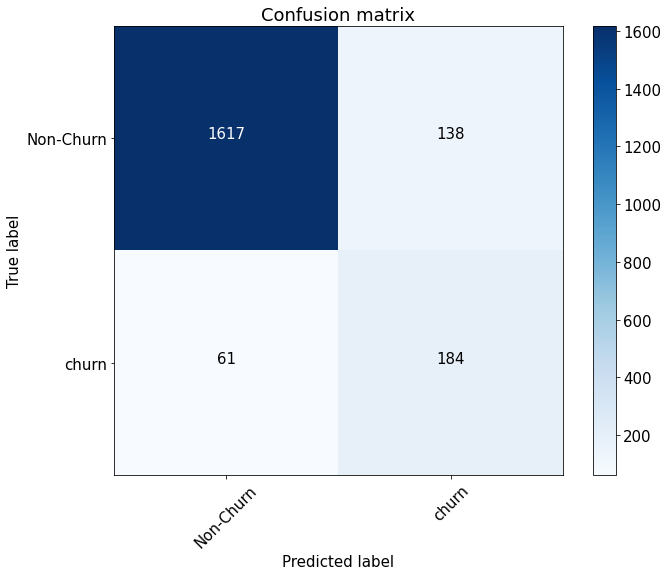

In [37]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [38]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.93992673992674

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

In [39]:
# roc_auc, precision, recall, f_score
# mean, median, max, idf_mean
score_compare = pd.DataFrame({
    "method": ['mean'], 
    "roc_auc_score": [roc_auc], 
    "precision": [precision[ix]], 
    "recall": [recall[ix]], 
    "f_score": [fscore[ix]]
})
score_compare

,method,roc_auc_score,precision,recall,f_score
0,mean,0.939927,0.572755,0.755102,0.651408


### Выполняем непосредственно само задание. 
Модифицируем код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана

In [40]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [41]:
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.013689,0.000000,0.151484,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.099146,0.000000,0.0,0.015243,0.212766
1,u108690,0.000000,0.000000,0.189868,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.013509,0.006238,0.117574,0.000000,0.013257,0.0,0.148009,0.122771
2,u108339,0.000000,0.006499,0.096405,0.096353,0.0,0.0,0.0,0.0,0.0,...,0.049296,0.009879,0.005139,0.049845,0.000000,0.000000,0.067832,0.0,0.080345,0.172493


In [42]:
X = pd.merge(user_embeddings_median, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.013689,0.000000,0.151484,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.099146,0.000000,0.0,0.015243,0.212766,0
1,u108690,0.000000,0.000000,0.189868,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.013509,0.006238,0.117574,0.000000,0.013257,0.0,0.148009,0.122771,1
2,u108339,0.000000,0.006499,0.096405,0.096353,0.0,0.0,0.0,0.0,0.0,...,0.009879,0.005139,0.049845,0.000000,0.000000,0.067832,0.0,0.080345,0.172493,1


In [43]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [44]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [45]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.16137745, 0.01440981, 0.539575  , 0.1958635 , 0.02039855,
       0.10190662, 0.12099514, 0.02761719, 0.04267297, 0.18756074])

#### Рассчитаем Precision, Recall, F_score

In [46]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.803109, F-Score=nan, Precision=0.000, Recall=0.000


<ipython-input-46-010bf5497cf3>:2: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


Confusion matrix, without normalization
[[1755    0]
 [ 245    0]]


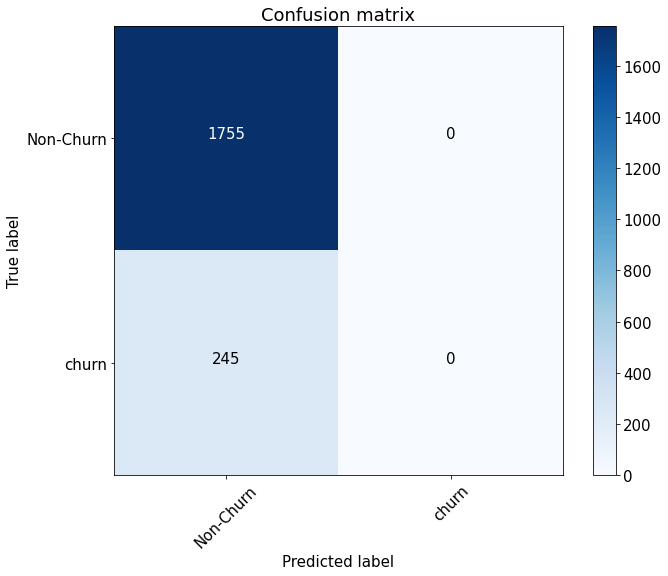

In [47]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [48]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9617628931914647

In [49]:
score_compare = pd.concat([score_compare, pd.DataFrame({
    "method": ['median'], 
    "roc_auc_score": [roc_auc], 
    "precision": [precision[ix]], 
    "recall": [recall[ix]], 
    "f_score": [fscore[ix]]
})], axis=0, ignore_index=True)

score_compare

,method,roc_auc_score,precision,recall,f_score
0,mean,0.939927,0.572755,0.755102,0.651408
1,median,0.961763,0.000000,0.000000,NaN


### 3. Повторить п.2, но используя уже не медиану, а max

#### Выполняем непосредственно само задание. 
Модифицируем код функции get_user_embedding таким образом, чтобы считалось максимальное значение

In [50]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [51]:
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.107292,0.050467,0.448531,0.249828,0.000000,0.050813,0.017276,0.141912,0.033781,...,0.027044,0.321984,0.049517,0.323886,0.182161,0.280751,0.141598,0.123119,0.093491,0.318917
1,u108690,0.056318,0.000000,0.373062,0.259603,0.014484,0.171119,0.000000,0.045095,0.044125,...,0.039795,0.116241,0.021172,0.084598,0.244742,0.150962,0.056396,0.000000,0.290684,0.255535
2,u108339,0.081883,0.035498,0.202839,0.161698,0.036029,0.000000,0.000000,0.044382,0.045898,...,0.092293,0.304702,0.026960,0.151619,0.141595,0.082432,0.182899,0.000000,0.229646,0.401292


In [52]:
X = pd.merge(user_embeddings_max, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.107292,0.050467,0.448531,0.249828,0.000000,0.050813,0.017276,0.141912,0.033781,...,0.321984,0.049517,0.323886,0.182161,0.280751,0.141598,0.123119,0.093491,0.318917,0
1,u108690,0.056318,0.000000,0.373062,0.259603,0.014484,0.171119,0.000000,0.045095,0.044125,...,0.116241,0.021172,0.084598,0.244742,0.150962,0.056396,0.000000,0.290684,0.255535,1
2,u108339,0.081883,0.035498,0.202839,0.161698,0.036029,0.000000,0.000000,0.044382,0.045898,...,0.304702,0.026960,0.151619,0.141595,0.082432,0.182899,0.000000,0.229646,0.401292,1


In [53]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [54]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [55]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([6.59988390e-02, 1.87008913e-04, 8.38118085e-01, 4.42191893e-02,
       1.37024748e-02, 1.64184726e-03, 1.99916792e-01, 4.30988213e-03,
       2.07217070e-01, 5.98116084e-01])

#### Рассчитаем Precision, Recall, F_score

In [56]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.358014, F-Score=0.763, Precision=0.744, Recall=0.784


Confusion matrix, without normalization
[[1689   66]
 [  54  191]]


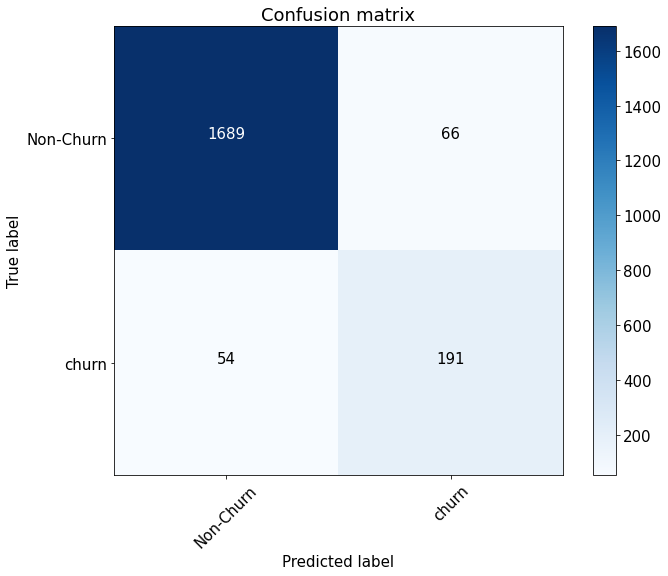

In [57]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [58]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9617605674748533

In [59]:
score_compare = pd.concat([score_compare, pd.DataFrame({
    "method": ['max'], 
    "roc_auc_score": [roc_auc], 
    "precision": [precision[ix]], 
    "recall": [recall[ix]], 
    "f_score": [fscore[ix]]
})], axis=0, ignore_index=True)

score_compare

,method,roc_auc_score,precision,recall,f_score
0,mean,0.939927,0.572755,0.755102,0.651408
1,median,0.961763,0.000000,0.000000,NaN
2,max,0.961761,0.744186,0.783673,0.763419


### 4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

### 5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [60]:
score_compare

,method,roc_auc_score,precision,recall,f_score
0,mean,0.939927,0.572755,0.755102,0.651408
1,median,0.961763,0.000000,0.000000,NaN
2,max,0.961761,0.744186,0.783673,0.763419


### 6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных